In [31]:
import matplotlib
font = {'family' : 'Dejavu Sans',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [1]:
import os
import urllib
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from graspologic.utils import import_edgelist
import numpy as np
import glob
from tqdm import tqdm

# the AWS bucket the data is stored in
BUCKET_ROOT = "open-neurodata"
parcellation = "Schaefer400"
FMRI_PREFIX = "m2g/Functional/BNU1-11-12-20-m2g-func/Connectomes/" + parcellation + "_space-MNI152NLin6_res-2x2x2.nii.gz/"
FMRI_PATH = os.path.join("datasets", "fmri")  # the output folder
DS_KEY = "abs_edgelist"  # correlation matrices for the networks to exclude

def fetch_fmri_data(bucket=BUCKET_ROOT, fmri_prefix=FMRI_PREFIX,
                    output=FMRI_PATH, name=DS_KEY):
    """
    A function to fetch fMRI connectomes from AWS S3.
    """
    # check that output directory exists
    if not os.path.isdir(FMRI_PATH):
        os.makedirs(FMRI_PATH)
    # start boto3 session anonymously
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    # obtain the filenames
    bucket_conts = s3.list_objects(Bucket=bucket, 
                    Prefix=fmri_prefix)["Contents"]
    for s3_key in tqdm(bucket_conts):
        # get the filename
        s3_object = s3_key['Key']
        # verify that we are grabbing the right file
        if name not in s3_object:
            op_fname = os.path.join(FMRI_PATH, str(s3_object.split('/')[-1]))
            if not os.path.exists(op_fname):
                s3.download_file(bucket, s3_object, op_fname)

def read_fmri_data(path=FMRI_PATH):
    """
    A function which loads the connectomes as adjacency matrices.
    """
    # import edgelists with graspologic
    # edgelists will be all of the files that end in a csv
    networks = [import_edgelist(fname) for fname in tqdm(glob.glob(os.path.join(path, "*.csv")))]
    return np.stack(networks, axis=0)

Matplotlib is building the font cache; this may take a moment.


In [2]:
fetch_fmri_data()
As = read_fmri_data()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [01:48<00:00,  1.03s/it]


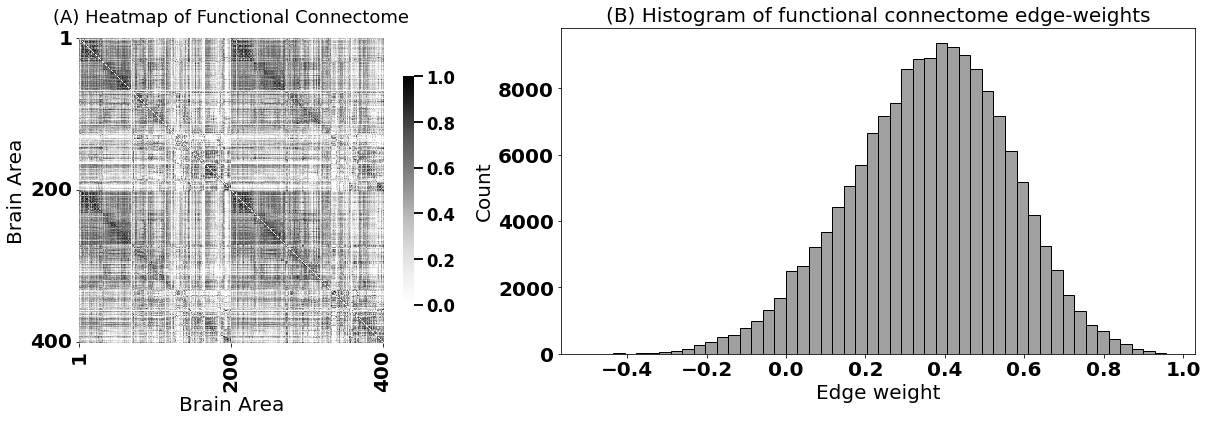

In [39]:
from graphbook_code import heatmap
from matplotlib import pyplot as plt

A = As[0]

fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1.2, 2]}, figsize=(20, 6))
heatmap(A, vmin=0, vmax=1, ax=axs[0], xticks=[0, 199, 399], xticklabels=[1, 200, 400],
        yticks=[0, 199, 399], yticklabels=[1, 200, 400], ytitle="Brain Area", xtitle="Brain Area",
        title="(A) Heatmap of Functional Connectome")
import seaborn as sns

sns.histplot(A.flatten(), ax=axs[1], bins=50, color="gray")
axs[1].set_xlabel("Edge weight")
axs[1].set_title("(B) Histogram of functional connectome edge-weights", size=20)
#fig.savefig("Figures/raw.svg")
fig.savefig("Figures/raw.png")